# PA005: High Values Customer Identification ( Insiders )

# 0.0. Planejamento da Solução ( IOT )

### Input - Entrada

1. Problema de Negócio
 - Selecionar os clientes mais valiosos para integrar um programa de Fidelização
2. Conjunto de Dados
 - Vendas de um e-commerce online, durante o periodo de um ano.

### Ouput - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade "INSIDERS".
    - Lista: client_id | is_insider |
               10235 | yes/1
               25482 | no/0

2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
    - Faturamento:
        - Alto Ticket Médio ( média de gastos )
        - Alto LTV ( total de gasto )
        - Baixa Recência ou Alta Frequência ( tempo entre as compras )
        - Alto Basket Size ( quantidade média de produtos comprados )
        - Baixa probabilidade de Churn
        - Previsão alta de LTV
        - Alta propensão de compra

    - Custo:
        - Baixo número de devoluções
        
    - Experiência:  
        - Média alta de avaliações

2. Quantos clientes farão parte do grupo?
    - Número de clientes
    - % em relação ao total de clients

3. Quais as principais características desses clientes ?
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    Escrever os principais comportamentos de compra dos clients ( métricas de negócio ) Vide acima

4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    

5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Cálculo do LTV do grupo InsidersSéries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    

7. Quais as condições para uma pessoa ser removida do Insiders ?
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    

8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste de Hipóteses
    - Teste A/B
    

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# Ciclo 0.1. Métricas de Validação de Cluster

1. Feature Engineering
    - Recência
    - Frequência
    - Monetizaçã0   
2. Métricas de validação de Clustering
    - WSS ( Within-Cluster Sum of Square ) 
    - SS ( Silhouette Score )    
3. Cluster Analysis
    - Plot 3D
    - Cluster Profile

# Ciclo 0.2. Análise de Silhouette

1. Feature Engineering
    - Average Ticket    
2. Análise de Silhouette
    - Silhouette Analysis    
3. Cluster Visualization
    - UMAP   
4. Cluster Análise de Perfil
    - Descrição dos centróides dos cluster

# Ciclo 0.3. Statistical Descriptive

1. Análise Descritiva
    - Atributos numéricos
    - Atibutos categóricos
2. Feature Engineering
    - Average Recency
    - Number of Returns
3. Data preparation
    - stander Scaler

# 0.0 Imports

In [130]:
import pandas  as pd
import numpy   as np
import seaborn as sns

import umap.umap_ as umap

from plotly import express as px

from pandas_profiling import ProfileReport

from sklearn import cluster       as c
from sklearn import metrics       as m
from sklearn import ensemble      as en
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn.manifold import TSNE


from IPython.display     import HTML
from matplotlib          import pyplot as plt

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer 

## 0.1. Helper Functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()    


jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [5]:
# load data
df_raw = pd.read_csv( '../data/raw/Ecommerce.csv', encoding='unicode_escape')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

# <font color='red'> 1.0. Descrição dos dados </font>

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print( f'Number of rows: {df1.shape[0]}')
print( f'Number of cols: {df1.shape[1]}')

Number of rows: 541909
Number of cols: 8


## 1.3. Data Types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [11]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [12]:
# crate reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup), 1)

# merge original with reference data frame
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [13]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change Dtypes

In [14]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributs

In [17]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### <font color='red' > 1.7.1.1 Numerical Attributs - Investigating </font>

1. Quantity negativa ( pode ser devolução )

2. Preço unitário igual a zero (  pode ser promoção )

### 1.7.2 Categorical Attributs

### invoice NO

In [18]:
# invoice number
# problema: invoice com letras e numeros

df_letter_invoices = df1.loc[ df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), : ]
df_letter_invoices.head()

print( f'Total de number of invoices: { len( df_letter_invoices )}')
print(f'Total de number of negative quantity: {len( df_letter_invoices[ df_letter_invoices["quantity"] < 0])}')

Total de number of invoices: 9291
Total de number of negative quantity: 9288


### stock code

In [19]:
# check stock codes only characters
df1.loc[ df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ),'stock_code'].unique()

# Ação:
## 1. Remover stock_code in ['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

### Description

In [20]:
df1.head()

# Ação : Delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


### Country

In [21]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [22]:
len( df1['country'].unique() )

38

In [23]:
df1['country'].value_counts( normalize=True ).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [24]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country').count().reset_index().sort_values( 'customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# <font color='red'> 2.0. Filtragem de Variáveis </font>

In [77]:
df2 = df1.copy()

In [78]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [79]:
# === Numerical attributes ===
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ===
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK']  )]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -  
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# quantity - Rivisão entre compra e decolução
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# <font color='red'> 3.0. Feature Engineering </font>

In [80]:
# Feature Ideas:
## Moving Average - 7d, 14d, 30d
## Quantidade de Compras por mês, antes do dia 15 e depois do dia 15
## Average Financial
## Basket Size * Price - Quantidade de preços por cesta

########
###
###
#######

In [81]:
df3 = df2.copy()

## 3.1. Feature Creation

In [82]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates( ignore_index=True )
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


## 3.1.1 Gross Revenue

In [83]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

/tmp/ipykernel_16821/206990356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

## 3.1.2 Recency - Day from last purchase

In [84]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum() # -> Check NA apos merge

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

## 3.1.3 Quantity of purchased

In [85]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' )
                                                                               .count()
                                                                               .reset_index()
                                                                               .rename( columns={'invoice_no': 'qtde_invoices'}))
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )  
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

## 3.1.4 Quantity total of items purchased

In [86]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' )
                                                           .sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'}))
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

In [87]:
df_freq.head()

,customer_id,qtde_items
0,12346,74215
1,12347,2458
2,12348,2332
3,12349,630
4,12350,196


## 3.1.4 Quantity products of stock_code

In [88]:
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' )
                                                              .count()
                                                              .reset_index()
                                                              .rename( columns={'stock_code': 'qtde_products'}))
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

## 3.1.5 Average Ticket Value

In [89]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

## 3.1.6 Average Recency Days

In [90]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

## 3.1.7 Frequency Purchase

In [91]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

## 3.1.8 Number of Returns

In [92]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

## 3.1.9. Basket Size - Quantidade de Items por Cesta ( Quantity )

 - Invoice No = Compra = purchase
 - Stock Code = Produto = Product
 - Quantity = Item = Item

In [93]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id')
                                                                          .agg( n_purchases=( 'invoice_no', 'nunique'),
                                                                                n_products=( 'quantity', 'sum'))
                                                                           .reset_index())
# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

## 3.2.0.  Unique Basket Size - Quantidade de produtos distinto por compra

In [94]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id')
                                                                          .agg( n_purchases=( 'invoice_no', 'nunique'),
                                                                                n_products=( 'stock_code', 'nunique'))
                                                                           .reset_index())
# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [95]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,0.333333


# <font color='red'> 4.0. EDA (Exploratory Data Analysis) </font>

In [96]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1. Univariate Analysis

- Notes

1. Clusters Coesos - Separados
2. Métricas
    - Min, Máximo, Range ( Dispersão )
    - média e Mediana
    - Coeficiente de Variação( CV )
    - Distribuição
    
    
!ls -l /home/cassiano/repos/customer_clustering/notebooks/output.html

In [71]:
#profile = ProfileReport( df4 )
#profile.to_file( 'output.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 33.00it/s]


## 4.1.1 Gross Revenue

In [97]:
df4.sort_values( 'gross_revenue', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.203390,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.163043,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,12.821429,0.127778,952.0,1521.586957,2.695652
3338,16446,168472.50,0.0,2.0,80997.0,3.0,56157.500000,205.000000,0.009709,80995.0,40498.500000,1.500000
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,2.601399,0.533512,3332.0,403.331658,8.974874


In [98]:
df3[df3['customer_id'] == 14646].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646


## 4.1.2. Qtde Items

In [99]:
 df4[df4['qtde_items'] == 196844]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.20339,288.0,2733.944444,9.708333


## 4.1.3. Qtde Products

In [100]:
 #df4[df4['qtde_products'] == 7838]
df3[df3['customer_id'] == 17841].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
1441,C536543,22632,-1,2016-11-29,2.10,United Kingdom,17841
1442,C536543,22355,-2,2016-11-29,0.85,United Kingdom,17841
2037,536557,21495,25,2016-11-29,0.42,United Kingdom,17841
2038,536557,46000R,2,2016-11-29,1.45,United Kingdom,17841
2039,536557,46000S,1,2016-11-29,1.45,United Kingdom,17841


 ## 4.1.4. Avg Ticket

In [101]:
#df4[df4['avg_ticket'] == 56157.5]
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,-80995,2017-12-07,2.08,United Kingdom,16446


 ## 4.1.5. Frequency

In [102]:
#df4[df4['frequency'] == 17]
df3[df3['customer_id'] == 17850]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850
5,536365,22752,2,2016-11-29,7.65,United Kingdom,17850
6,536365,21730,6,2016-11-29,4.25,United Kingdom,17850
7,536366,22633,6,2016-11-29,1.85,United Kingdom,17850
8,536366,22632,6,2016-11-29,1.85,United Kingdom,17850
47,536372,22632,6,2016-11-29,1.85,United Kingdom,17850


## 4.1.6. Average Basket Size

## 4.2. Bivariate Analysis

In [72]:
cols = ['customer_id']
df42 = df4.drop( cols, axis=1 )

<Figure size 1800x864 with 0 Axes>

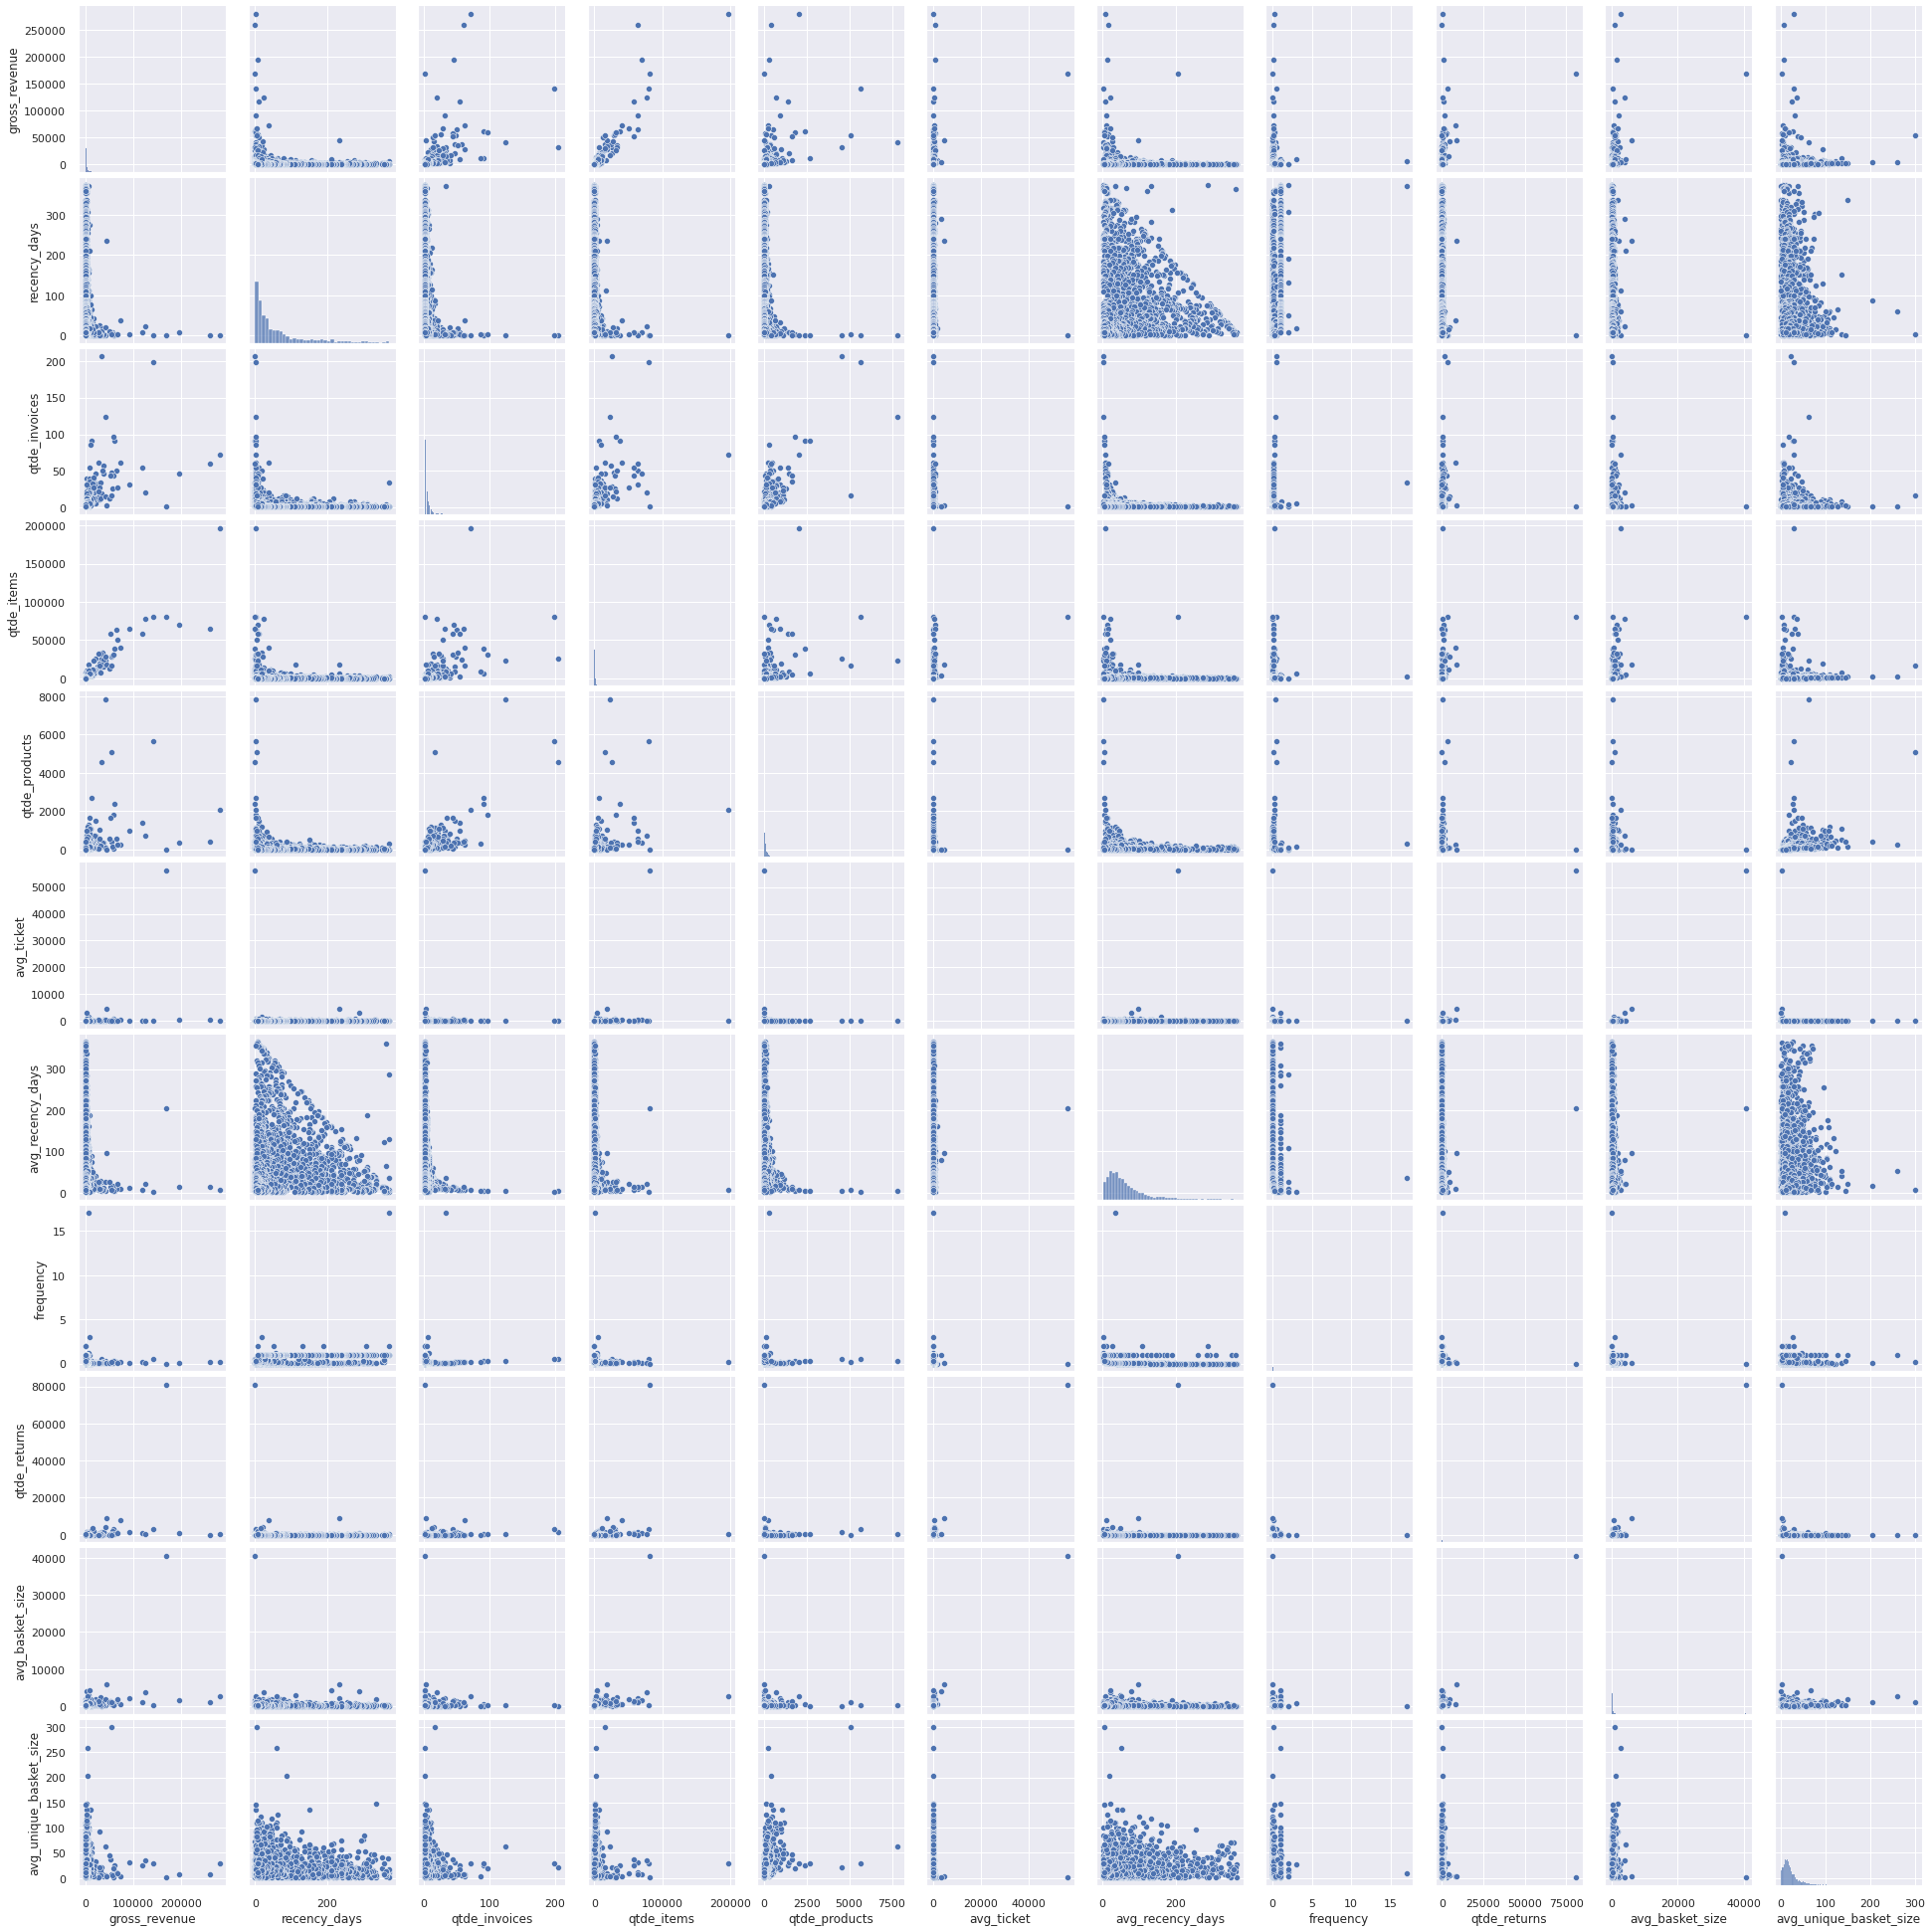

In [73]:
plt.figure( figsize=( 25, 12 ))
sns.pairplot( df42 )

# 4.3. Estudo do Espaço

In [111]:
df43 = df4.drop( columns=['customer_id'], axis=1 ).copy()

In [112]:
mm = pp.MinMaxScaler()

df43['gross_revenue']          = mm.fit_transform( df43[['gross_revenue']])
df43['recency_days']           = mm.fit_transform( df43[['recency_days']])
df43['qtde_invoices']          = mm.fit_transform( df43[['qtde_invoices']])
df43['qtde_items']             = mm.fit_transform( df43[['qtde_items']])
df43['qtde_products']          = mm.fit_transform( df43[['qtde_products']])
df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']])
df43['avg_recency_days']       = mm.fit_transform( df43[['avg_recency_days']])
df43['frequency']              = mm.fit_transform( df43[['frequency']])
df43['qtde_returns']           = mm.fit_transform( df43[['qtde_returns']])
df43['avg_basket_size']        = mm.fit_transform( df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']])

X = df43.copy()

## 4.3.1. PCA

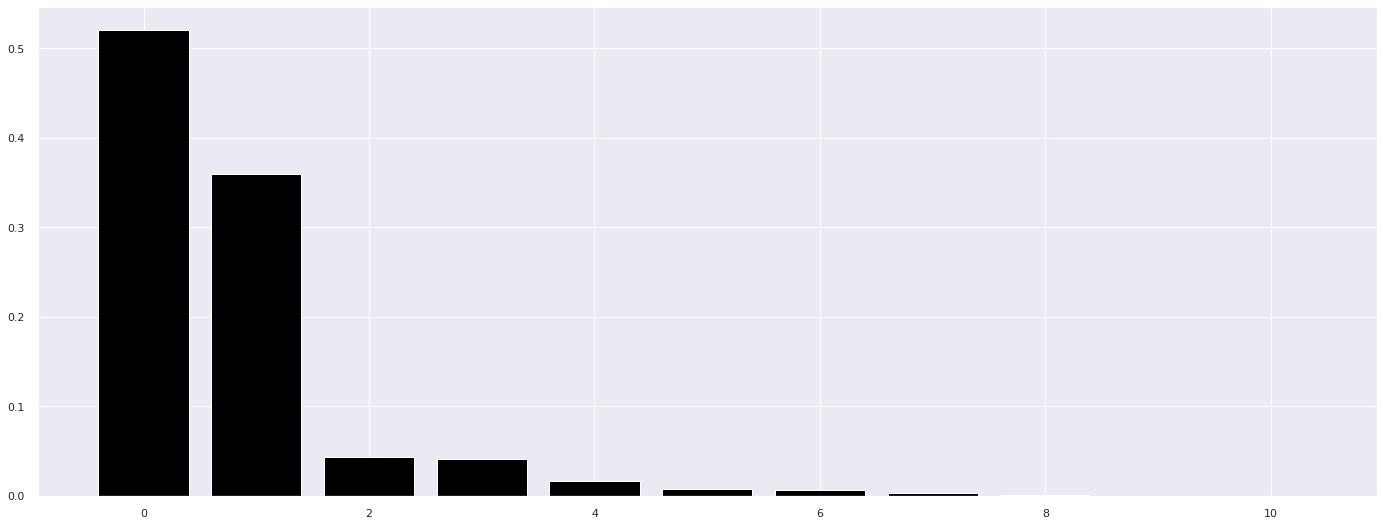

In [116]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

#plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame( principal_components )

<AxesSubplot:xlabel='0', ylabel='1'>

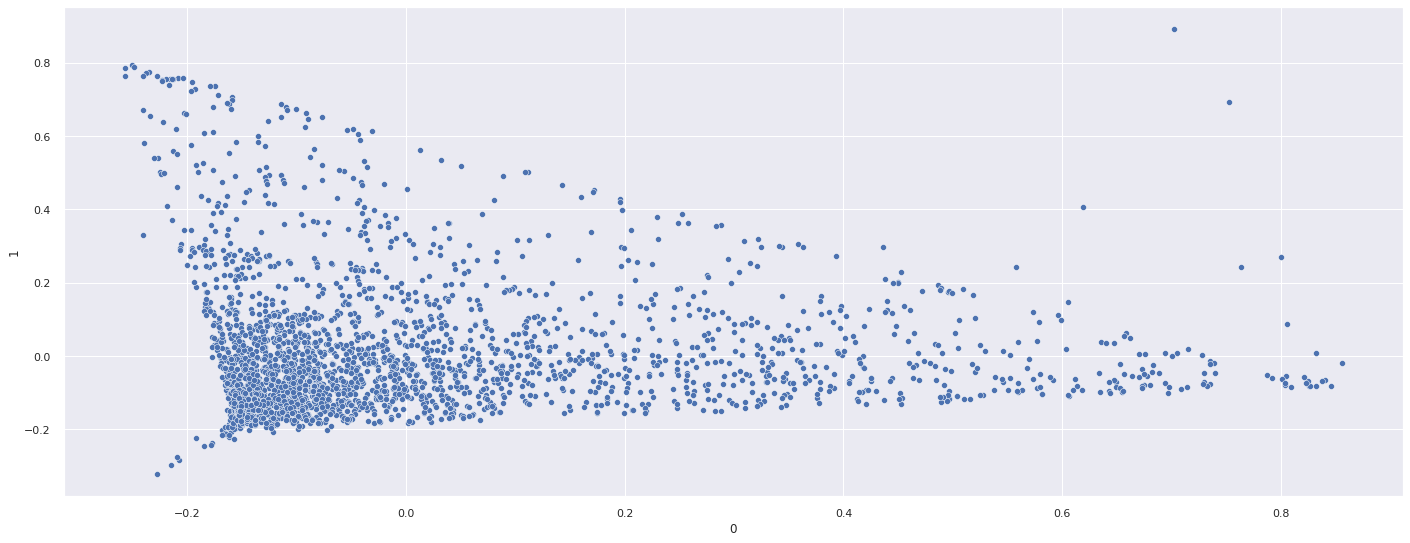

In [117]:
sns.scatterplot( x=0, y=1, data=df_pca)

## 4.3.2. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

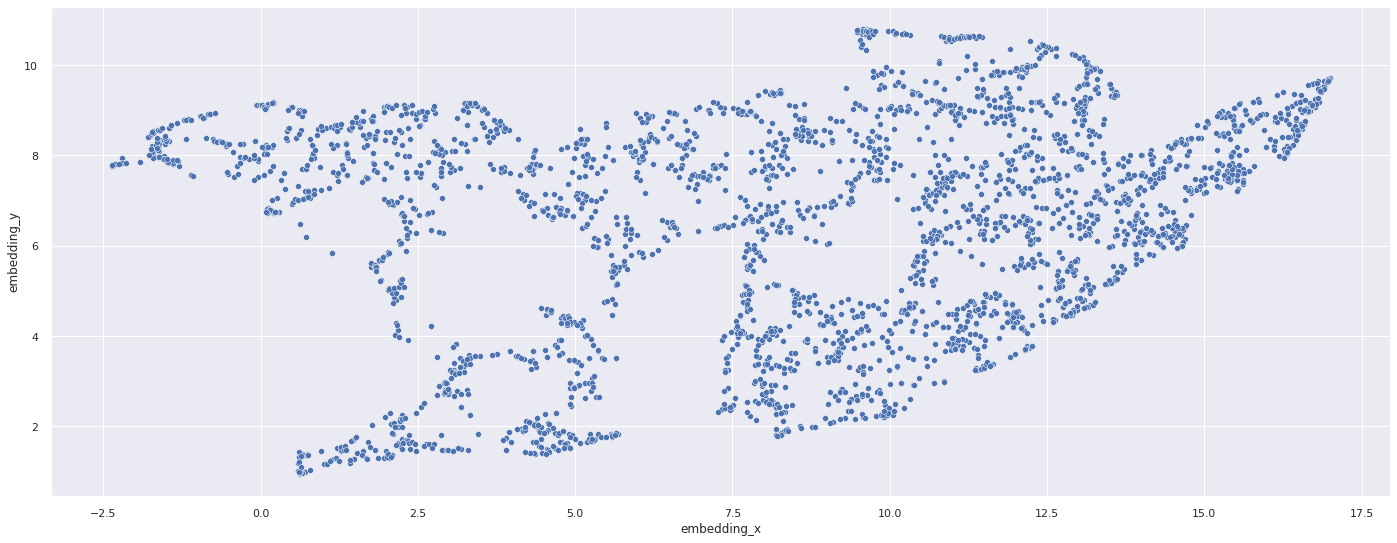

In [118]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y',
                 data=df_pca )

## 4.3.2. t-SNE

/opt/anaconda/envs/pa005_insiders_clustering/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda/envs/pa005_insiders_clustering/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

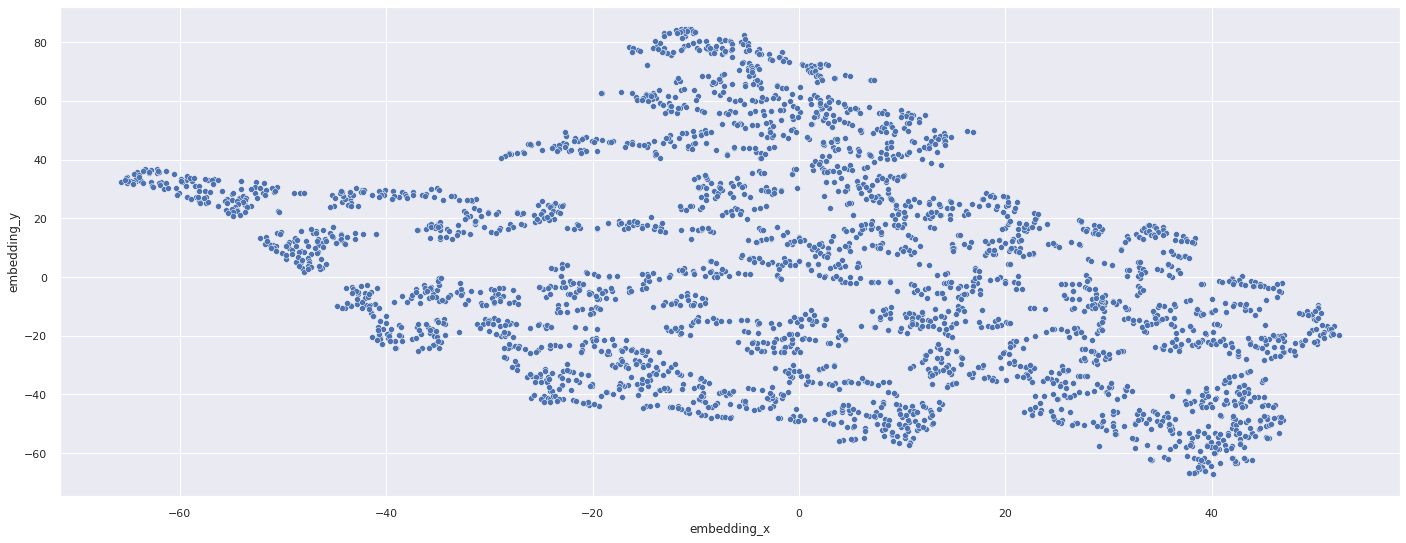

In [122]:
reducer =  TSNE( n_components=2,
                 n_jobs=-1,
                 random_state=42 )

embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y',
                 data=df_pca )

## 4.3.3 Tree-Based Embedding

In [131]:
# training dataset
X = df4.drop( columns=['customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf

# dataframe

RandomForestRegressor(random_state=42)

In [132]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

In [135]:
X.shape

(2969, 10)

In [133]:
df_leaf.shape

(2969, 100)

In [134]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2984,3165,3369,3328,3032,3149,3229,3126,3173,3126,3169,3099,3153,3188,3109,3085,3130,3190,3078,3254,3283,2670,2861,3290,2830,3124,3026,3231,3105,2959,3033,3388,3365,3347,2974,3047,3023,3136,2955,3057,3268,3151,3421,3161,3174,3086,3035,3334,3399,3108,3116,3206,3159,3399,3390,3203,3162,3075,3118,3101,3416,3180,3337,3243,2876,3057,3301,3320,3135,3266,3337,3281,2691,3270,3058,3167,3355,2980,3213,3166,3134,3321,3182,3078,3291,3162,3290,3376,3137,3266,3258,3227,3207,2798,3208,3133,3029,3367,3334,3292
1,2936,3110,3028,2952,3022,3147,2938,2802,3109,3034,3120,3049,3089,3117,2794,3119,2707,3077,2808,2418,3253,3094,2810,2829,3149,3120,2924,2878,3026,3097,2980,3008,2971,2962,2929,2959,2967,2796,2966,2911,2961,2782,2949,3116,3122,2938,3011,2880,3012,2919,3178,3123,3077,2977,2987,2959,2714,3022,3067,3109,2991,2832,2905,3204,2854,2494,3000,2925,2845,2959,2959,2980,2949,2880,3102,2507,2861,2906,3178,3150,3024,2922,3143,2785,2895,3146,2944,2982,3101,2839,2502,2920,2951,2758,3137,3055,2935,2925,2976,2830
2,3490,3617,3577,3405,3593,3618,3537,3545,3701,3615,3599,3591,3547,3628,3522,3556,3580,3652,3601,3477,3481,3652,3606,3525,3609,3590,3489,3605,3538,3721,3451,3672,3605,3650,3580,3635,3548,3508,3593,3477,3659,3399,3697,3615,3593,3589,3604,3643,3644,3608,3571,3495,3610,3617,3664,3663,3620,3649,3538,3413,3603,3617,3584,3654,3471,3627,3633,3641,3620,3609,3581,3429,3586,3530,3613,3563,3588,3541,3655,3596,3517,3440,3545,3540,3603,3620,3580,3702,3541,3393,3602,3473,3564,3544,3615,3564,3576,3615,3592,3665
3,2129,1963,1570,1598,1829,1508,2105,1787,2043,2115,2064,1510,1311,1599,1602,1843,1866,1585,1940,1387,1828,1235,1491,1571,2173,1981,1584,1945,1457,1513,1824,1558,1368,1576,1395,1833,1554,2148,1518,1800,1778,1429,1369,1768,1603,1492,1532,1380,2051,1237,1583,1564,1338,2186,2104,2020,1589,1721,1467,2124,1574,2122,1762,1824,1544,1512,2133,2073,1536,2079,2318,1614,1992,2207,1665,1546,1347,1543,1949,1946,2124,1438,1731,1554,1430,1842,1521,2156,1357,1324,1804,1366,2052,2082,2050,2168,1526,1000,2179,2103
4,216,270,298,594,175,468,725,693,174,165,599,160,689,953,705,717,199,209,586,704,518,702,467,213,646,195,559,528,140,760,699,867,197,338,220,619,433,197,538,586,739,723,451,606,723,546,935,661,700,621,610,960,737,562,564,572,725,208,724,587,229,244,559,188,663,438,568,731,693,607,580,190,603,615,701,345,704,585,602,183,200,334,563,331,587,215,288,852,355,801,422,209,684,586,693,739,575,907,697,207


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

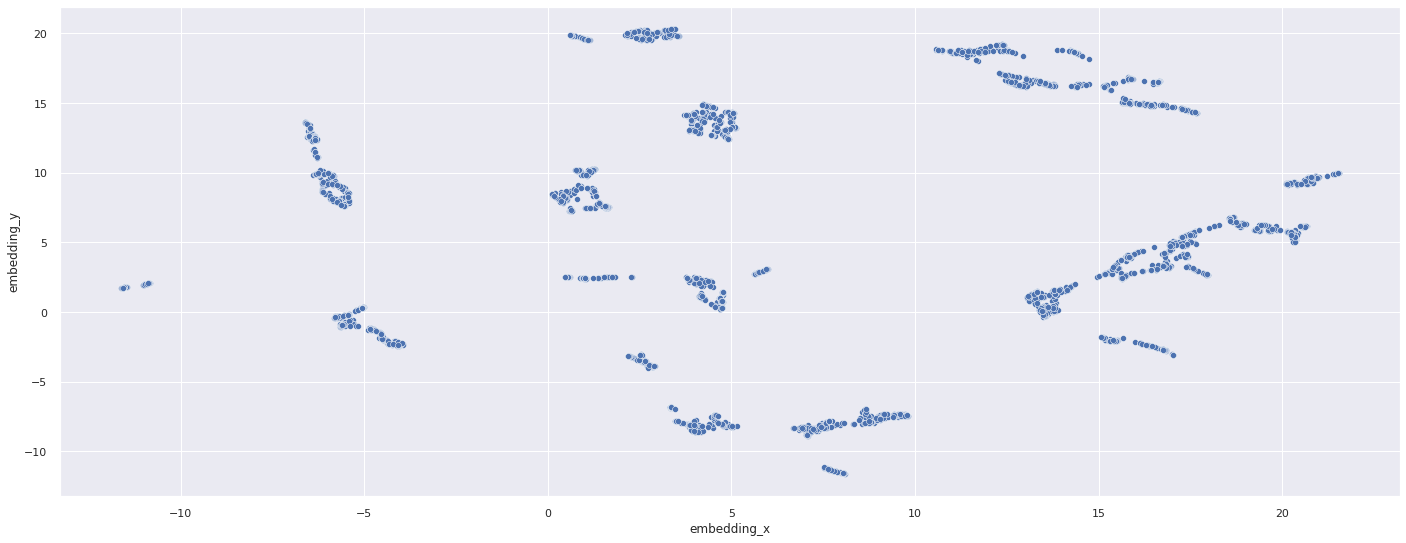

In [138]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y',
                 data=df_pca )

# <font color='red'> 5.0. Data Preparation </font>

In [172]:
df5 = df4.copy()

In [174]:
# Standard Scaler
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform( df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']])

# <font color='red'> 6.0. Feature Selection </font>

In [178]:
df6 = df5.copy()

# <font color='red'> 7.0. Hyperparameter Fine-Tunning </font>

In [179]:
X = df6.drop( columns=['customer_id'])

In [180]:
clusters = [ 2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluster Sum of Square ( WSS )                                    

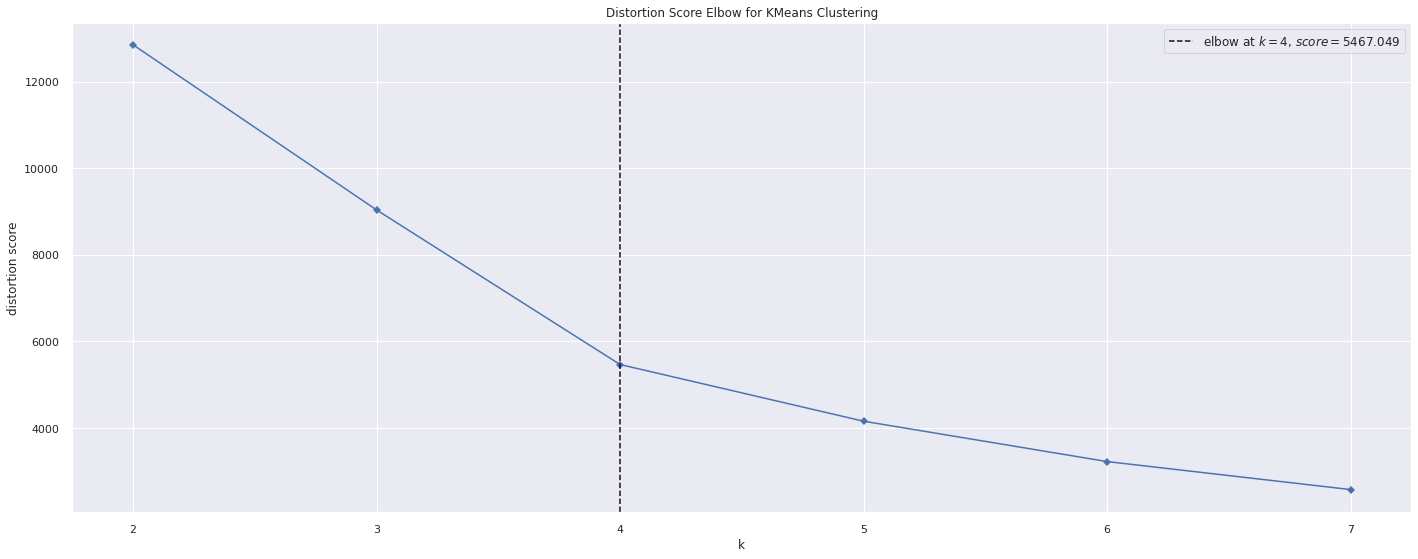

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [181]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show()

## 7.2. Sillhouette Score

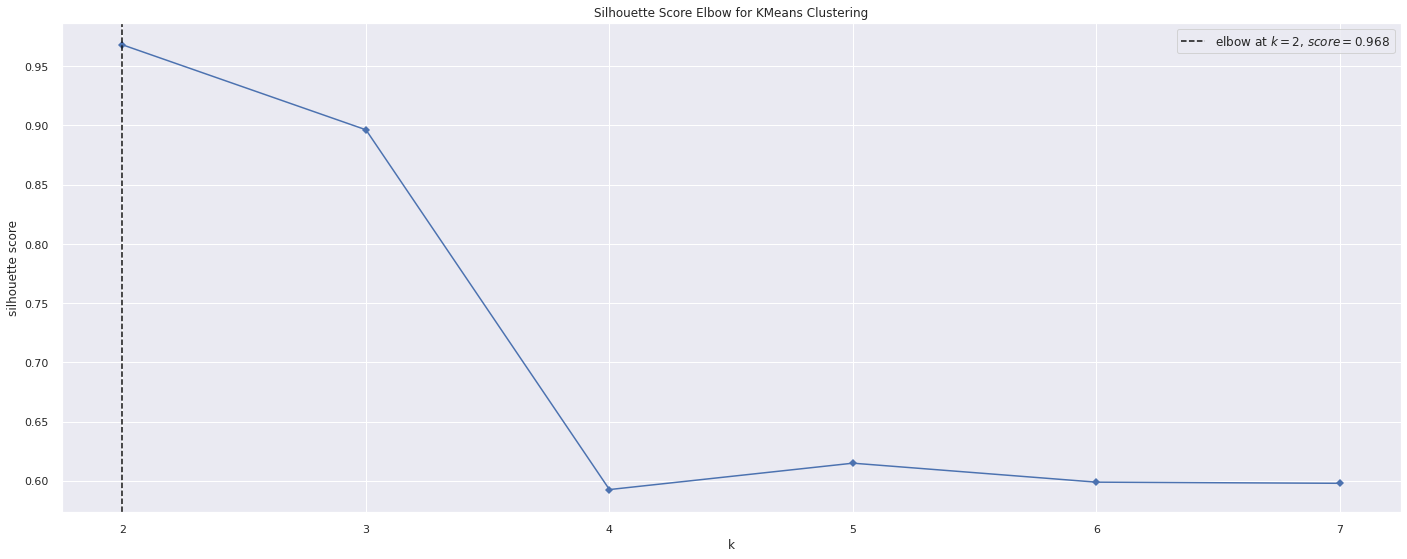

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [182]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

## 7.3. Silhouette Analysis

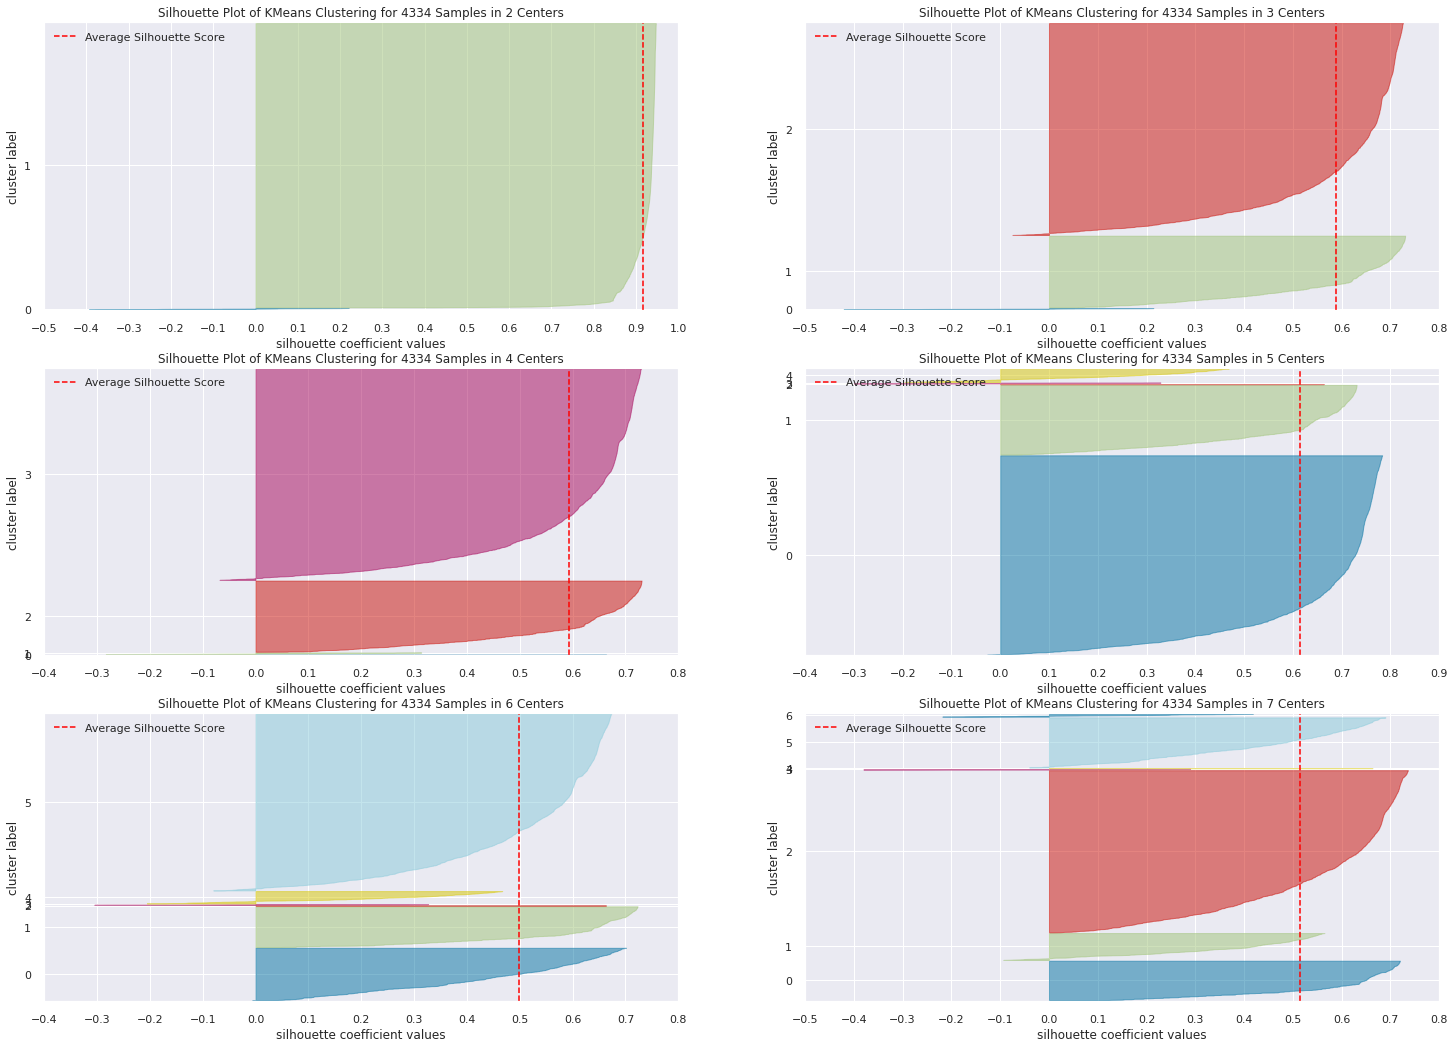

In [183]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize()

# <font color='red'> 8.0. Model Training </font>

## 8.1. K-Means

In [184]:
# model definition
k = 3 
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

## 8.1. Clusters Validation

In [185]:
# WSS ( Within-cluter sum of square )
print( f'WSS Value: { kmeans.inertia_}')

# SS ( Silhouette Score )
print( f'SS Value: { m.silhouette_score( X, labels, metric="euclidean")}')

WSS Value: 9420.062067546805
SS Value: 0.588752375906376


# <font color='red'> 9.0. Cluster Analysis </font>

In [186]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.378347,2.793160,3.897513,-0.033914,2
1,13047,0.135982,-0.361673,0.622737,-0.033402,0
2,12583,0.525899,-0.900791,1.408683,-0.026594,0
3,13748,-0.120499,0.027689,0.098772,-0.023214,0
4,15100,-0.128611,2.403798,-0.163210,0.152554,2


## 9.1. Visualization Inspection

/opt/anaconda/envs/pa005_insiders_clustering/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


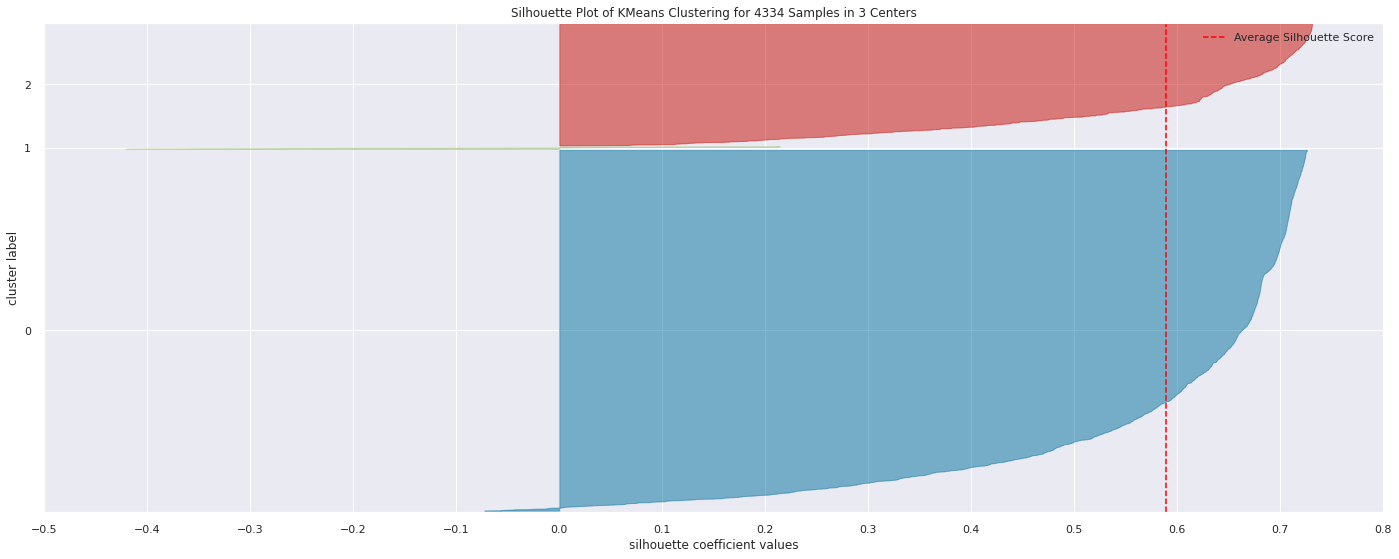

In [187]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick')
visualizer.fit( X )
visualizer.finalize()

## 9.2. 2d plot

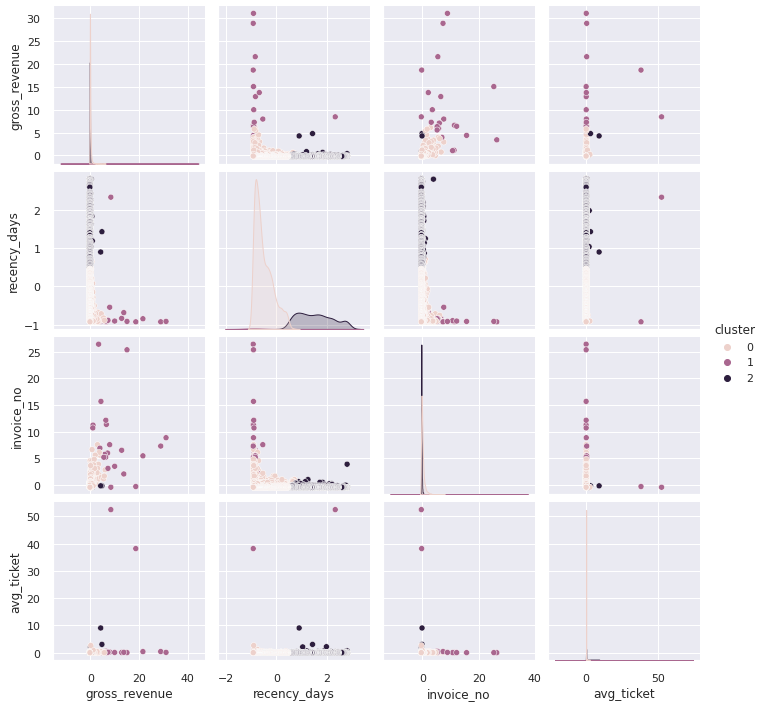

In [188]:
df_viz = df9.drop( columns='customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster')

## 9.3. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

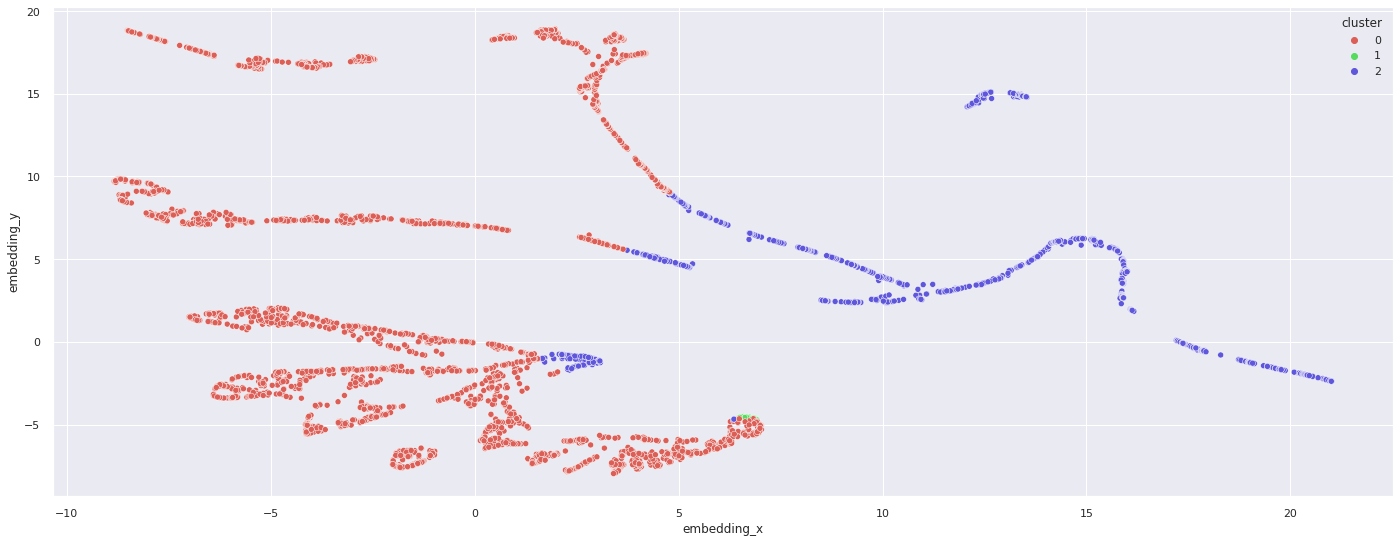

In [189]:
reducer = umap.UMAP( n_neighbors=20, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y',
               hue='cluster',
               palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
               data=df_viz )

## 9.1. Cluster Profile

In [190]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how='inner', on='cluster')

#Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,3225,74.411629,-0.015019,-0.513580,0.060511,-0.02567
1,1,22,0.507614,10.334967,-0.723354,8.440522,4.19143
2,2,1087,25.080757,-0.164611,1.538370,-0.350357,-0.00867


### Cluster 00:  
- Número de customers: 4071 (93% do customers )
- Recência em média: 96 dias
- Compras em média: 4 compras
- Receita em média: 946,00 dólares
- Ticket médio: 25,00 dólares

### Cluster 01: 
- Número de customers: 6 (0.14% do customers )
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: 182.182,00 dólares
- Ticket médio: 254,00 dólares

### Cluster 02:
- Número de customers: 28 (0.64 do customers )
- Recência em média: 6 dias
- Compras em média: 57 compras
- Receita em média: 42.614,38 dólares
- Ticket médio: 163,00 dólares

### Cluster 03:
- Número de customers: 267 (6% do customers )
- Recência em média: 20 dias
- Compras em média: 19 compras
- Receita em média: 8.089,02 dólares
- Ticket médio: $63,00 dólares


# <font color='red'> 10.0. Deploy To Production </font>